# The Battle of Neighborhoods
## Applied Data Science Capstone Project
### Fuat Akal

## Table of contents
* [Problem](#problem)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Problem <a name="problem"></a>

Istanbul is the most populous and diverse city in Turkey. It is located between two continents, Europe and Asia. Being the economic locomotive and historic capital of Turkey, Istanbul attracts millions of people as residents from several different ethnicities. It is also an important destinations for tourists from all over the world.

Food Diversity is an important aspect of mega cities. The objective of this project is to segment districts of Istanbul into major clusters based on their their cuisines, probably to investigate food habits and taste of these clusters. For this purpose, the venue data provided by Foursquare will be used for clustering, which will be done by using the k-means clustering machine learning algorithm. Possible stakeholders would be the ones who are interested in opening new restaurants in Istanbul or the ones who want to explore different tastes in Istanbul.

## Data <a name="data"></a>

In this project, two main data sources are used. The first one is a wiki page containing list of districts of Istanbul. 
Unfortunately, i was not able to a perfect data set like the ones we have in the Coursera assignments 
(e.g. the New York dataset). So, I had to scrape a wiki page for the list of district names in Istanbul 
and then look for coordinates of them explicitly. The second one is the Foursquare API to get venues in districts of Istanbul.

## Methodology <a name="methodology"></a>

I applied the following steps to solve the problem at hand:

1. I partly obtained the data from the Web, which is the list of districts in Istanbul. I was not able to go in to neighborhood detail due to lack of public data. then, i construct a data frame of districts along with their coordinates.

2. Then, i used the Foursquare API to get the list of venues in those districts. The venues I am interested in are about food. Furthermore, I removed general food places like cafes.

3. After that, I marked the food venues on the Istanbul map.

4. Once the places are determined, I used the k-means clustering algorithm. Before that, I tried to find the optimum number of clusters, which was 7 in my experiments.

5. Finally, I found clusters and marked them on the Istanbul map.


In [106]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
from pprint import pprint # data pretty printer
import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from collections import Counter # count occurrences 
from sklearn.cluster import KMeans # import k-means from clustering stage

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [35]:
# This function returns coordinates of a district in a city
def get_coordinates(district, city='Istanbul', country='Turkey'):
    try:
        address = district + ", " + city + ", " + country

        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude

        return [latitude, longitude]
    except:
        return [None, None]

In [16]:
url = 'https://en.wikipedia.org/wiki/List_of_districts_of_Istanbul'

# Get a list of wikitables on the page
# pd.read_html returns a list
tables = pd.read_html(url, attrs={"class":"wikitable"})

# Check how many wikitables exist in the tables list.
# print(len(tables))

In [21]:
# I examined the tables and noticed the first element is the table I am looking for.
# Then, I convert it into a dataframe
# Four rows at the bottom are irrelevant. So, drop them.
df = pd.DataFrame(tables[0]['District'])[:-4]
df.head()

,District
0,Adalar
1,Arnavutköy
2,Ataşehir
3,Avcılar
4,Bağcılar


In [43]:
# Now, I have the names of districts.
# Next step is to find the coordinates of them.

column_names = ['district', 'latitude', 'longitude']
df_dist = pd.DataFrame(columns = column_names)

# Turkish characters make the get_coordinates function fail. So, translate them.
translationTable = str.maketrans("ğĞıİöÖüÜşŞçÇ", "gGiIoOuUsScC")

for index, row in df.iterrows():
    # access data using column names
    print(index, row['District'])
    row['District'].translate(translationTable)
    ll = get_coordinates(row['District'].translate(translationTable))
    new_row = {'district':row['District'], 'latitude':ll[0], 'longitude':ll[1]}
    #append row to the dataframe
    df_dist = df_dist.append(new_row, ignore_index=True)    


# In case get_coordinates fails to return a coordinate
df_dist.dropna(axis=0, inplace=True)

0 Adalar
[40.87625945, 29.091027262109563]
1 Arnavutköy
[41.0683942, 29.0411538]
2 Ataşehir
[40.9847487, 29.1067199]
3 Avcılar
[40.9801353, 28.7175465]
4 Bağcılar
[41.0338992, 28.8578982]
5 Bahçelievler
[41.0533837, 29.0797099]
6 Bakırköy
[40.9835414, 28.8679735]
7 Başakşehir
[41.0976935, 28.8061626]
8 Bayrampaşa
[41.051452299999994, 28.89830467611224]
9 Beşiktaş
[41.0428465, 29.0075283]
10 Beykoz
[41.1239355, 29.1083151]
11 Beylikdüzü
[41.0010788, 28.642054]
12 Beyoğlu
[41.0284233, 28.9736808]
13 Büyükçekmece
[41.0156913, 28.5955238]
14 Çatalca
[None, None]
15 Çekmeköy
[41.04021, 29.1750588]
16 Esenler
[41.0332539, 28.8909528]
17 Esenyurt
[41.0342402, 28.6800178]
18 Eyüpsultan
[41.0460444, 28.9253241]
19 Fatih
[41.019297, 28.9478024]
20 Gaziosmanpaşa
[41.0575263, 28.9156504]
21 Güngören
[41.0228713, 28.8726289]
22 Kadıköy
[40.9915716, 29.0270173]
23 Kağıthane
[41.08598, 28.9726208]
24 Kartal
[40.8884921, 29.1896017]
25 Küçükçekmece
[41.0002141, 28.7808891]
26 Maltepe
[40.9235417, 29.1

,district,latitude,longitude
0,Adalar,40.876259,29.091027
1,Arnavutköy,41.068394,29.041154
2,Ataşehir,40.984749,29.106720
3,Avcılar,40.980135,28.717547
4,Bağcılar,41.033899,28.857898
5,Bahçelievler,41.053384,29.079710
6,Bakırköy,40.983541,28.867974
7,Başakşehir,41.097693,28.806163
8,Bayrampaşa,41.051452,28.898305
9,Beşiktaş,41.042847,29.007528


In [47]:
# Now, i have district names and their coordinates
df_dist.head()

,district,latitude,longitude
0,Adalar,40.876259,29.091027
1,Arnavutköy,41.068394,29.041154
2,Ataşehir,40.984749,29.106720
3,Avcılar,40.980135,28.717547
4,Bağcılar,41.033899,28.857898


In [51]:
# Create map of Istanbul using latitude and longitude values
# Get the coordinates of Istanbul
ll = get_coordinates('', 'Istanbul', 'Turkey')
map_istanbul = folium.Map(location=[ll[0], ll[1]], zoom_start=10)

# add markers to map
for lat, lng, district in zip(df_dist['latitude'], df_dist['longitude'], df_dist['district']):
    label = district
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_istanbul)  
    
map_istanbul

In [52]:
# Define Foursquare credentials and version

CLIENT_ID = 'YAHGYUPV1LNVZYAX2NFTCOJLZ4VV2IJATEGPH45QTADAUCZF' # your Foursquare ID
CLIENT_SECRET = 'JZNNWIIYVA0WIVQI1VP2EDX3D3OCV0DJCI3RGC2Z0RVHPYLF' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YAHGYUPV1LNVZYAX2NFTCOJLZ4VV2IJATEGPH45QTADAUCZF
CLIENT_SECRET:JZNNWIIYVA0WIVQI1VP2EDX3D3OCV0DJCI3RGC2Z0RVHPYLF


In [ ]:
# Note that, i found and modified the code in the following four cells on Internet.

In [53]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [58]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

In [56]:
# Fetch Foursquare Venue Category Hierarchy
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

category_list = category_results['response']['categories']

# This function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

In [63]:
#Let's use pickle library to serialize the information retrieved from GET requests. This step will counter any redundant requests to the Foursquare API.

import pickle # to serialize and deserialize a Python object structure
try:
    with open('istanbul_food_venues.pkl', 'rb') as f:
        istanbul_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    istanbul_venues = getNearbyFood(names=df_dist['district'],
                                        latitudes=df_dist['latitude'],
                                        longitudes=df_dist['longitude']
                                       )
    with open('istanbul_food_venues.pkl', 'wb') as f:
        pickle.dump(istanbul_venues, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


## Analysis <a name="analysis"></a>

In [66]:
# Let's see how many rows are returned
istanbul_venues.shape

(1798, 7)

In [65]:
# Take a look at the data
istanbul_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adalar,40.876259,29.091027,Asaf Mangalbasi,40.879398,29.089971,BBQ Joint
1,Adalar,40.876259,29.091027,Heybeliada Keyif Cafe,40.878490,29.094755,Café
2,Adalar,40.876259,29.091027,Heybeliada Su Sporları Kulübü,40.882365,29.089167,Pool
3,Adalar,40.876259,29.091027,Heybeli Ada Cafe,40.878047,29.100374,Fast Food Restaurant
4,Adalar,40.876259,29.091027,Zehra Heybeliada,40.877453,29.100646,Seafood Restaurant


In [67]:
# Let's check venue categories
print('There are {} uniques categories.'.format(len(istanbul_venues['Venue Category'].unique())))
istanbul_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 109 uniques categories.


Venue Category
Café                                        533
Coffee Shop                                 158
Restaurant                                  112
Seafood Restaurant                           79
Turkish Restaurant                           75
Bakery                                       65
Dessert Shop                                 65
Steakhouse                                   47
Kebab Restaurant                             47
Fast Food Restaurant                         46
Breakfast Spot                               39
Burger Joint                                 29
Ice Cream Shop                               26
Doner Restaurant                             26
Tea Room                                     23
Bagel Shop                                   21
Soup Place                                   21
Cafeteria                                    21
Kofte Place                                  16
Pizza Place                                  15
Hookah Bar               

In [68]:
# As we are interested in exploring the diversity of the neighborhood, 
# Let's remove the generalized categories, like Coffee Shop, Cafe, etc.

unique_categories = istanbul_venues['Venue Category'].unique().tolist()

# manually created list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))

# Let's remove all the generalized categories, like Coffee Shop, Cafe, etc.
istanbul_venues = istanbul_venues[istanbul_venues['Venue Category'].isin(food_categories)].reset_index()
istanbul_venues.head(5)


,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Adalar,40.876259,29.091027,Asaf Mangalbasi,40.879398,29.089971,BBQ Joint
1,2,Adalar,40.876259,29.091027,Heybeliada Su Sporları Kulübü,40.882365,29.089167,Pool
2,3,Adalar,40.876259,29.091027,Heybeli Ada Cafe,40.878047,29.100374,Fast Food Restaurant
3,4,Adalar,40.876259,29.091027,Zehra Heybeliada,40.877453,29.100646,Seafood Restaurant
4,5,Adalar,40.876259,29.091027,Zehra Restaurant,40.877361,29.100491,Seafood Restaurant


In [70]:
print('There are {} unique FOOD categories.'.format(len(istanbul_venues['Venue Category'].unique())))

There are 56 unique FOOD categories.


In [71]:
# one hot encoding
istanbul_onehot = pd.get_dummies(istanbul_venues[['Venue Category']], prefix="", prefix_sep="")
istanbul_onehot.head()

,African Restaurant,American Restaurant,Arepa Restaurant,BBQ Joint,Bed & Breakfast,Borek Place,Bosnian Restaurant,Cajun / Creole Restaurant,Caucasian Restaurant,Chocolate Shop,Cigkofte Place,Coworking Space,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,Fish Taverna,French Restaurant,Fried Chicken Joint,General Entertainment,German Restaurant,Greek Restaurant,Halal Restaurant,Historic Site,Indian Restaurant,Italian Restaurant,Kebab Restaurant,Kofte Place,Kokoreç Restaurant,Kumpir Restaurant,Kumru Restaurant,Manti Place,Mediterranean Restaurant,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Military Base,Noodle House,Office,Other Great Outdoors,Performing Arts Venue,Pide Place,Pilavcı,Pizza Place,Pool,Rest Area,Seafood Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tantuni Restaurant,Tibetan Restaurant,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [75]:
# Add district column back to dataframe
istanbul_onehot['district'] = istanbul_venues['Neighborhood'] 

# Move district column to the first column
district = istanbul_onehot['district']
istanbul_onehot.drop(labels=['district'], axis=1,inplace = True)
istanbul_onehot.insert(0, 'district', district)

istanbul_onehot.head()

,district,African Restaurant,American Restaurant,Arepa Restaurant,BBQ Joint,Bed & Breakfast,Borek Place,Bosnian Restaurant,Cajun / Creole Restaurant,Caucasian Restaurant,Chocolate Shop,Cigkofte Place,Coworking Space,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,Fish Taverna,French Restaurant,Fried Chicken Joint,General Entertainment,German Restaurant,Greek Restaurant,Halal Restaurant,Historic Site,Indian Restaurant,Italian Restaurant,Kebab Restaurant,Kofte Place,Kokoreç Restaurant,Kumpir Restaurant,Kumru Restaurant,Manti Place,Mediterranean Restaurant,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Military Base,Noodle House,Office,Other Great Outdoors,Performing Arts Venue,Pide Place,Pilavcı,Pizza Place,Pool,Rest Area,Seafood Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tantuni Restaurant,Tibetan Restaurant,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,Adalar,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [76]:
#Let's count venues of each category in each neighborhood

venue_counts = istanbul_onehot.groupby('district').sum()
venue_counts.head(5)

,African Restaurant,American Restaurant,Arepa Restaurant,BBQ Joint,Bed & Breakfast,Borek Place,Bosnian Restaurant,Cajun / Creole Restaurant,Caucasian Restaurant,Chocolate Shop,Cigkofte Place,Coworking Space,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,Fish Taverna,French Restaurant,Fried Chicken Joint,General Entertainment,German Restaurant,Greek Restaurant,Halal Restaurant,Historic Site,Indian Restaurant,Italian Restaurant,Kebab Restaurant,Kofte Place,Kokoreç Restaurant,Kumpir Restaurant,Kumru Restaurant,Manti Place,Mediterranean Restaurant,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Military Base,Noodle House,Office,Other Great Outdoors,Performing Arts Venue,Pide Place,Pilavcı,Pizza Place,Pool,Rest Area,Seafood Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tantuni Restaurant,Tibetan Restaurant,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
district,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adalar,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,9,1,0,0,0,0,0,0,1,0
Arnavutköy,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,13,0,1,0,0,0,0,0,1,1
Ataşehir,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,3,0,0,1,0,0,0,0,0
Avcılar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0
Bahçelievler,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,2,0


In [77]:
# Let's find out the top 10 food categories in Istanbul

venue_counts_described = venue_counts.describe().transpose()
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Seafood Restaurant,36.0,2.194444,3.105934,0.0,0.0,1.0,2.25,13.0
Kebab Restaurant,36.0,1.305556,1.653040,0.0,0.0,1.0,2.00,8.0
Turkish Restaurant,36.0,2.083333,1.610235,0.0,1.0,2.0,3.00,6.0
Fast Food Restaurant,36.0,1.277778,1.185896,0.0,0.0,1.0,2.00,5.0
Steakhouse,36.0,1.305556,1.283287,0.0,0.0,1.0,2.00,5.0
Kofte Place,36.0,0.444444,0.808683,0.0,0.0,0.0,1.00,3.0
Pizza Place,36.0,0.416667,0.691789,0.0,0.0,0.0,1.00,3.0
Doner Restaurant,36.0,0.722222,0.848902,0.0,0.0,0.5,1.00,3.0
Meyhane,36.0,0.222222,0.540429,0.0,0.0,0.0,0.00,2.0
Italian Restaurant,36.0,0.111111,0.398410,0.0,0.0,0.0,0.00,2.0


In [83]:
venue_top10_list = venue_top10.index.values.tolist()

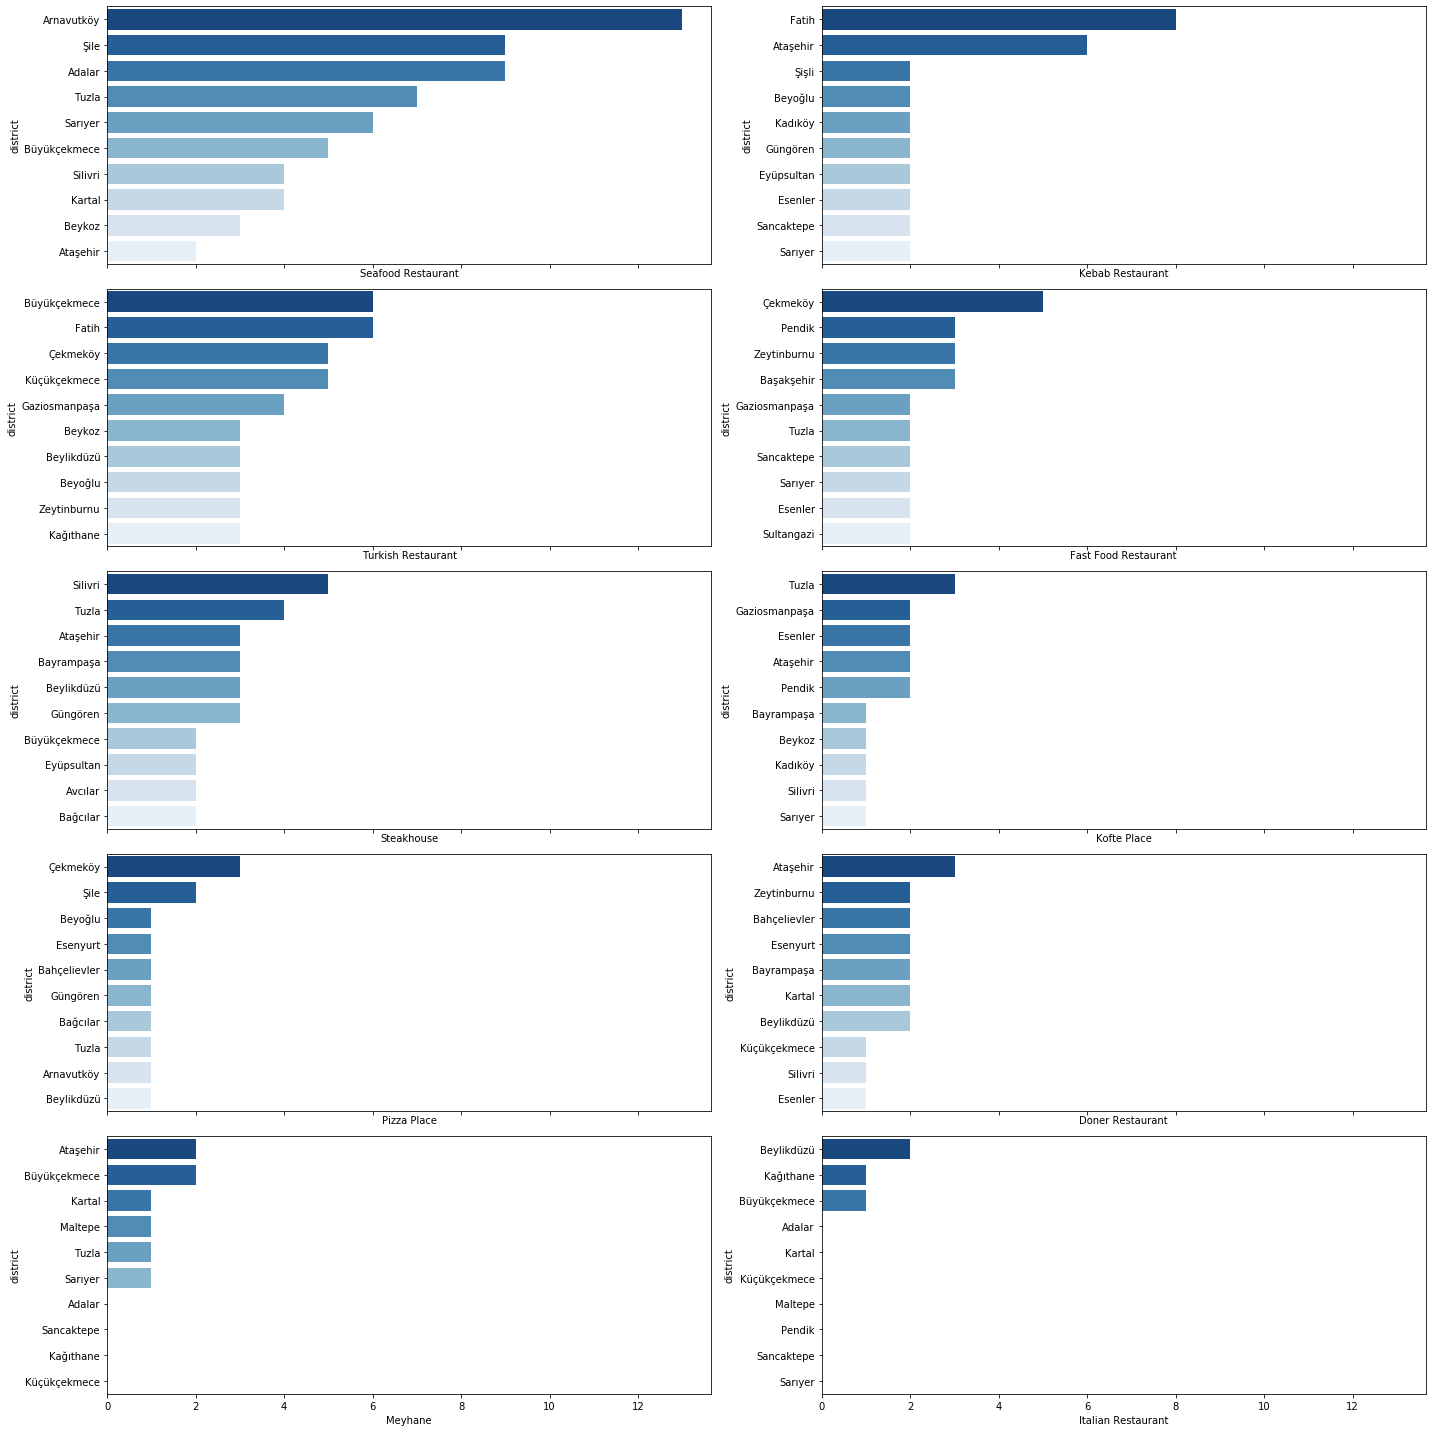

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

In [78]:
#Next, let's group rows by district and by taking the mean of the frequency of occurrence of each category

istanbul_grouped = istanbul_onehot.groupby('district').mean().reset_index()
istanbul_grouped.head()

,district,African Restaurant,American Restaurant,Arepa Restaurant,BBQ Joint,Bed & Breakfast,Borek Place,Bosnian Restaurant,Cajun / Creole Restaurant,Caucasian Restaurant,Chocolate Shop,Cigkofte Place,Coworking Space,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,Fish Taverna,French Restaurant,Fried Chicken Joint,General Entertainment,German Restaurant,Greek Restaurant,Halal Restaurant,Historic Site,Indian Restaurant,Italian Restaurant,Kebab Restaurant,Kofte Place,Kokoreç Restaurant,Kumpir Restaurant,Kumru Restaurant,Manti Place,Mediterranean Restaurant,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Military Base,Noodle House,Office,Other Great Outdoors,Performing Arts Venue,Pide Place,Pilavcı,Pizza Place,Pool,Rest Area,Seafood Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tantuni Restaurant,Tibetan Restaurant,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,Adalar,0.055556,0.0,0.0,0.055556,0.0,0.0,0.0,0.000000,0.0,0.0,0.055556,0.0,0.000000,0.0,0.0,0.055556,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.055556,0.0,0.000000,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.000000,0.055556,0.0,0.500000,0.055556,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.055556,0.000000
1,Arnavutköy,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.045455,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.045455,0.045455,0.0,0.045455,0.045455,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.045455,0.000000,0.0,0.590909,0.000000,0.045455,0.0,0.000000,0.0,0.0,0.000000,0.045455,0.045455
2,Ataşehir,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.157895,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.315789,0.105263,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.105263,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.105263,0.157895,0.000000,0.0,0.052632,0.0,0.0,0.000000,0.000000,0.000000
3,Avcılar,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.250000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.500000,0.000000,0.0,0.000000,0.0,0.0,0.250000,0.000000,0.000000
4,Bahçelievler,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.153846,0.0,0.0,0.153846,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.153846,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.076923,0.000000,0.0,0.000000,0.076923,0.000000,0.0,0.000000,0.0,0.0,0.153846,0.153846,0.000000


In [79]:
# This function sorts the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [80]:
# Now let's create the new dataframe and display the top 5 venues for each neighborhood.
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['district']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))    

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['district'] = istanbul_grouped['district']

for ind in np.arange(istanbul_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(istanbul_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adalar,Seafood Restaurant,Steakhouse,Other Great Outdoors,Cigkofte Place,Mediterranean Restaurant
1,Arnavutköy,Seafood Restaurant,Sushi Restaurant,Mediterranean Restaurant,Pizza Place,Manti Place
2,Ataşehir,Kebab Restaurant,Steakhouse,Doner Restaurant,Meyhane,Seafood Restaurant
3,Avcılar,Steakhouse,Turkish Home Cooking Restaurant,Manti Place,Vegetarian / Vegan Restaurant,Dumpling Restaurant
4,Bahçelievler,Kebab Restaurant,Turkish Restaurant,Fast Food Restaurant,Doner Restaurant,Turkish Home Cooking Restaurant


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

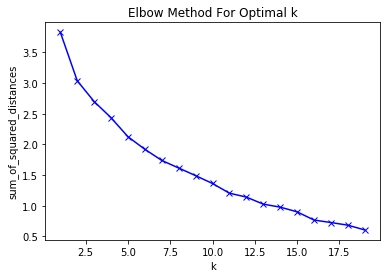

In [85]:
# Run k-means to count districts for each cluster label for variable cluster size

istanbul_grouped_clustering = istanbul_grouped.drop('district', 1)

# Try for k values from1 to 20
sum_of_squared_distances = []
K = range(1,20)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(istanbul_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)
    
# Plot results to determine the best k value    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

In [86]:
# It seems 7 is a good value for k.

# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(istanbul_grouped_clustering)

print(Counter(kmeans.labels_))


Counter({3: 9, 1: 7, 0: 7, 7: 4, 2: 3, 6: 3, 4: 2, 5: 1})


In [87]:
# Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted.head(5)

,Cluster Labels,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,2,Adalar,Seafood Restaurant,Steakhouse,Other Great Outdoors,Cigkofte Place,Mediterranean Restaurant
1,2,Arnavutköy,Seafood Restaurant,Sushi Restaurant,Mediterranean Restaurant,Pizza Place,Manti Place
2,1,Ataşehir,Kebab Restaurant,Steakhouse,Doner Restaurant,Meyhane,Seafood Restaurant
3,5,Avcılar,Steakhouse,Turkish Home Cooking Restaurant,Manti Place,Vegetarian / Vegan Restaurant,Dumpling Restaurant
4,1,Bahçelievler,Kebab Restaurant,Turkish Restaurant,Fast Food Restaurant,Doner Restaurant,Turkish Home Cooking Restaurant


In [88]:
# Add latitude/longitude for each district
istanbul_merged = neighborhoods_venues_sorted.join(df_dist.set_index('district'), on='district')
istanbul_merged.head()

,Cluster Labels,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,latitude,longitude
0,2,Adalar,Seafood Restaurant,Steakhouse,Other Great Outdoors,Cigkofte Place,Mediterranean Restaurant,40.876259,29.091027
1,2,Arnavutköy,Seafood Restaurant,Sushi Restaurant,Mediterranean Restaurant,Pizza Place,Manti Place,41.068394,29.041154
2,1,Ataşehir,Kebab Restaurant,Steakhouse,Doner Restaurant,Meyhane,Seafood Restaurant,40.984749,29.106720
3,5,Avcılar,Steakhouse,Turkish Home Cooking Restaurant,Manti Place,Vegetarian / Vegan Restaurant,Dumpling Restaurant,40.980135,28.717547
4,1,Bahçelievler,Kebab Restaurant,Turkish Restaurant,Fast Food Restaurant,Doner Restaurant,Turkish Home Cooking Restaurant,41.053384,29.079710


In [89]:
# Finally, let's visualize the resulting clusters

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(istanbul_merged['latitude'], istanbul_merged['longitude'], istanbul_merged['district'], istanbul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


## Results<a name="results"></a>

In [91]:
required_column_indices = [2,3,7]
required_column = [list(istanbul_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]

In [92]:
# This function returns a desired cluster
def cluster_n(df_merged, n):
    return df_merged.loc[df_merged['Cluster Labels'] == n, df_merged.columns[1:12]]

In [104]:
# Examine clusters
for i in range(6):
    print("\n\nExamining cluster #", i)
    print("---------------------------------------------")
    cluster = cluster_n(istanbul_merged, i)

    for col in required_column:
        print("\n")
        print(cluster[col].value_counts(ascending = False))




Examining cluster # 0
---------------------------------------------


Turkish Restaurant    4
Seafood Restaurant    2
Kebab Restaurant      1
Name: 1st Most Common Venue, dtype: int64


Seafood Restaurant    3
Kebab Restaurant      1
Doner Restaurant      1
Historic Site         1
Turkish Restaurant    1
Name: 2nd Most Common Venue, dtype: int64


40.991572    1
41.042847    1
40.923542    1
41.015691    1
41.028423    1
40.888492    1
41.123936    1
Name: latitude, dtype: int64


Examining cluster # 1
---------------------------------------------


Kebab Restaurant        4
Fast Food Restaurant    1
Kofte Place             1
Steakhouse              1
Name: 1st Most Common Venue, dtype: int64


Steakhouse              3
Fast Food Restaurant    2
Turkish Restaurant      1
Kebab Restaurant        1
Name: 2nd Most Common Venue, dtype: int64


41.046044    1
41.033899    1
41.022871    1
41.109240    1
41.053384    1
41.033254    1
40.984749    1
Name: latitude, dtype: int64


Examining 

## Discussion <a name="discussion"></a>

## Conclusion <a name="conclusion"></a>

### Thank You

* References: Notebook created by [Alex Aklson](https://www.linkedin.com/in/aklson/) and [Polong Lin](https://www.linkedin.com/in/polonglin/) for the course on **Coursera** called *Applied Data Science Capstone*

<hr>